## Try SAM on the Bees 

To create a SAM environment

conda create --name ultralytics-env python=3.8 -y

conda activate ultralytics-env

conda install -c pytorch -c nvidia -c conda-forge pytorch torchvision pytorch-cuda=11.8 ultralytics

original min max 0 255


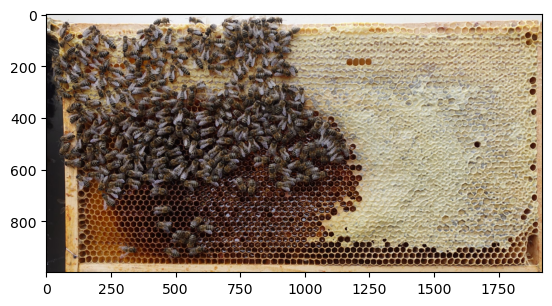

In [26]:
from pathlib import Path
import numpy as np
import matplotlib.backends
import matplotlib.pyplot as plt
from skimage.io import imread

tnia_images_path = Path(r'D:/images')


parent_path=Path(tnia_images_path / r'tnia-python-images/imagesc/2023_12_20_segmenting_bees')
test_name='bsp1-2.jpg'

testim = imread(parent_path  / test_name) 
testim.shape
plt.imshow(testim, cmap="gray")
print('original min max', testim.min(), testim.max())

In [27]:
from ultralytics.models.sam import Predictor as SAMPredictor

import logging                                                                 
logging.getLogger('ultralytics').setLevel(logging.CRITICAL) 

In [28]:
def make_label_image(label_image, masks):
    '''
    Creates a label image by adding one mask at a time onto an empty image, given the masks from an ultralytics prediction

    Inputs:
    - A label image of zeros, in the same size and shape of your original image.
    - A list of masks from an ultralytics segmentation
    Outputs:
    - A label-image of all masks
    '''
    for enum, mask in enumerate(masks):
        curr_label = mask.data.cpu().numpy() # Converts from tensors to a numpy compatible array on the CPU
        mnarray = curr_label.squeeze() # reduce each mask into 2D array
        label_image[mnarray] = enum + 1 # set each mask to a unique ID (enum)

    return(label_image)

In [29]:
# Create SAMPredictor
from ultralytics import SAM 
model_base = SAM("sam_b.pt") # Downloads base model - it's about 300MB.

In [32]:
def apply_sam_b(testim):
    results = model_base.predict(testim)
    masks = results[0].masks # Ultralytics masks are in the results
    array_shape = [masks.shape[1], masks.shape[2]] # Getting the 2D shape
    label_image_zeros = np.zeros(array_shape, dtype=np.int32) # Creates a label image of zeros
    return make_label_image(label_image_zeros, masks)

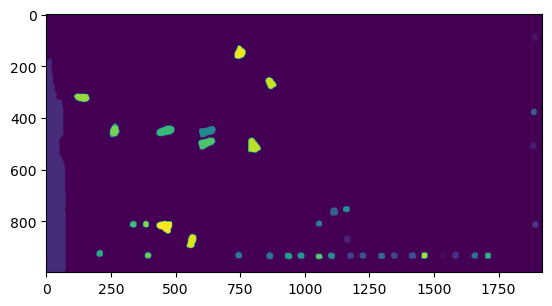

In [33]:
labels_full = apply_sam_b(testim)
plt.imshow(labels_full)

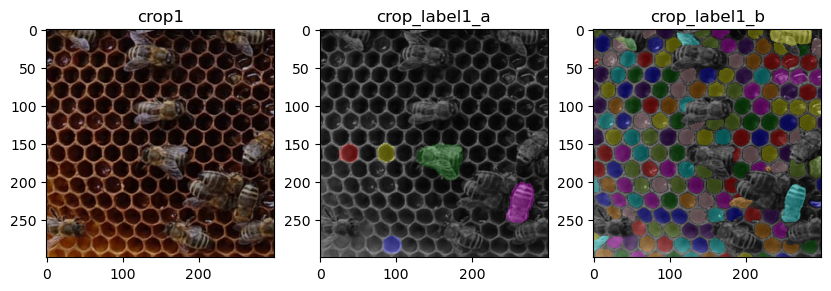

In [41]:
crop1ind = np.s_[650:950, 300:600]
crop1 = testim[crop1ind]
crop_label1_a = labels_full[crop1ind]
crop_label1_b = apply_sam_b(crop1)

from tnia.plotting.plt_helper import imshow_multi2d
from skimage import color
from skimage import segmentation

overlay_a = color.label2rgb(crop_label1_a, image=crop1, bg_label=0)
overlay_b = color.label2rgb(crop_label1_b, image=crop1, bg_label=0)
fig = imshow_multi2d([crop1, overlay_a, overlay_b], ['crop1', 'crop_label1_a', 'crop_label1_b'], 1, 3)

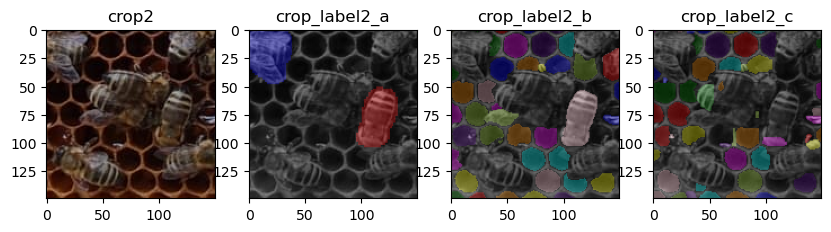

In [42]:
crop2ind = np.s_[150:300, 150:300]
crop2 = crop1[crop2ind]
crop_label2_a = crop_label1_a[crop2ind]
crop_label2_b = crop_label1_b[crop2ind]
crop_label2_c = apply_sam_b(crop2)

overlay_a = color.label2rgb(crop_label2_a, image=crop2, bg_label=0)
overlay_b = color.label2rgb(crop_label2_b, image=crop2, bg_label=0)
overlay_c = color.label2rgb(crop_label2_c, image=crop2, bg_label=0)

fig = imshow_multi2d([crop2, overlay_a, overlay_b, overlay_c], ['crop2', 'crop_label2_a', 'crop_label2_b', 'crop_label2_c'], 1, 4)

In [9]:
import napari
viewer = napari.Viewer()
viewer.add_image(testim, name='original')
viewer.add_labels(label_image, name='SAM segmentation')

<Labels layer 'SAM segmentation' at 0x1994d844bb0>

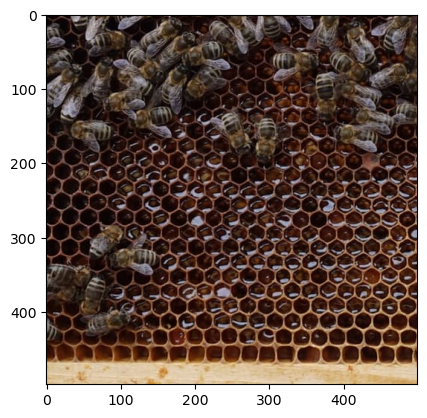

In [16]:
crop = testim[500:1000, 500:1000]
plt.imshow(crop)

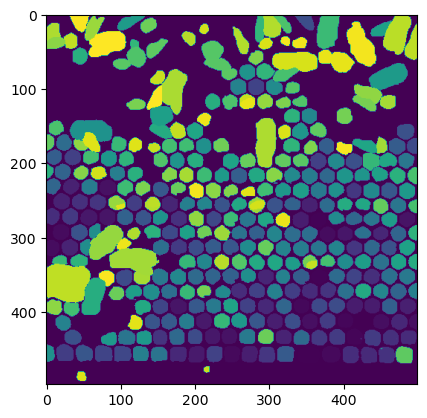

In [19]:

plt.imshow(label_image)

In [20]:
import napari
viewer = napari.Viewer()
viewer.add_image(crop, name='original')
viewer.add_labels(label_image, name='SAM segmentation')

<Labels layer 'SAM segmentation' at 0x147beb84a30>

In [21]:
crop2 = crop[:150,:150]